In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np

In [3]:
df = pd.read_csv('/content/drive/MyDrive/Classroom/trum_tweet_sentiment_analysis.csv')

In [4]:
df.head()

,text,Sentiment
0,RT @JohnLeguizamo: #trump not draining swamp b...,0
1,ICYMI: Hackers Rig FM Radio Stations To Play A...,0
2,Trump protests: LGBTQ rally in New York https:...,1
3,"""Hi I'm Piers Morgan. David Beckham is awful b...",0
4,RT @GlennFranco68: Tech Firm Suing BuzzFeed fo...,0


In [5]:
df.dropna()

,text,Sentiment
0,RT @JohnLeguizamo: #trump not draining swamp b...,0
1,ICYMI: Hackers Rig FM Radio Stations To Play A...,0
2,Trump protests: LGBTQ rally in New York https:...,1
3,"""Hi I'm Piers Morgan. David Beckham is awful b...",0
4,RT @GlennFranco68: Tech Firm Suing BuzzFeed fo...,0
...,...,...
1850118,Everytime im like 'How the fuck I follow Melan...,0
1850119,RT @imgur: The Trump Handshake. https://t.co/R...,0
1850120,"""Greenspan warns Trump's policies risk inflati...",0
1850121,RT @FasinatingLogic: We must also #INVESTIGATE...,1


In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, LSTM, Dense, Dropout
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [7]:
def text_cleaning_pipeline(dataset, rule = "lemmatize"):
  """
  This...
  """
  # Convert the input to small/lower order.
  data = dataset.lower()
  # Remove URLs
  data = re.sub(r"http\S+|www\S+|https\S+", '',data, flags=re.MULTILINE)
  # Remove emojis
  data = re.sub(r"["
                        u"\U0001F600-\U0001F64F"  # emoticons
                        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                        u"\U0001F680-\U0001F6FF"  # transport & map symbols
                        u"\U0001F1E0-\U0001F1FF"  # flags
                        u"\u2702-\u27B0"          # dingbats
                        u"\u24C2-\U0001F251"      # enclosed characters
                        "]+",
                        r' ', data, flags=re.UNICODE)
  # Remove mentions
  data = re.sub("@[A-Za-z0-9_]+"," ", data)
  # Remove all other unwanted characters.
  data = re.sub("[^0-9A-Za-z ]", "" , data)
  # Create tokens.
  tokens = data.split()
  # Remove stopwords:
  stop_words = set(stopwords.words('english'))
  result_tokens = []
  for token in tokens:
    if token not in stop_words:
      result_tokens.append(token)
  if rule == "lemmatize":
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in result_tokens]
  elif rule == "stem":
    stemmer = PorterStemmer()
    tokens = [stemmer.stem(token) for token in result_tokens]
  else:
    print("Pick between lemmatize or stem")


  return " ".join(tokens)


In [8]:
df['clean_text'] = df['text'].apply(lambda x: text_cleaning_pipeline(x, rule="lemmatize"))

In [9]:
X = df['clean_text']
y = df['Sentiment']

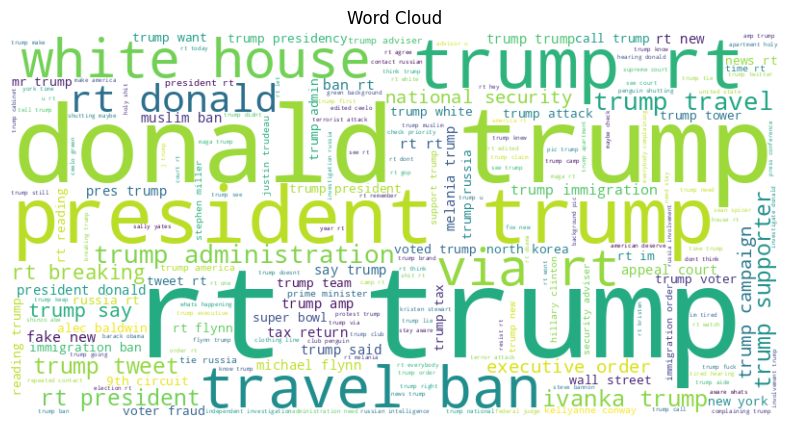

In [10]:
from wordcloud import WordCloud
all_clean_text = " ".join(df['clean_text'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_clean_text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud")
plt.show()

In [11]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [12]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")

tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

max_length = max([len(x) for x in X_train_seq])
print(max_length)


28


In [13]:
from keras.models import Sequential
from keras.layers import Embedding, SimpleRNN, Dense

X_train_padded = pad_sequences(X_train_seq, padding='post', maxlen=28)
X_test_padded = pad_sequences(X_test_seq, padding='post', maxlen=28)

rnn_model = Sequential()
rnn_model.add(Embedding(input_dim=10000, output_dim=128))
rnn_model.add(SimpleRNN(64))
rnn_model.add(Dense(1, activation='sigmoid'))

rnn_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

rnn_model.build(input_shape=(None, 28))
rnn_model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 28, 128)        │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ (None, 64)             │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,292,417 (4.93 MB)

 Trainable params: 1,292,417 (4.93 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
lstm_model = Sequential()
lstm_model.add(Embedding(input_dim=10000, output_dim=128))
lstm_model.add(LSTM(64))
lstm_model.add(Dense(1, activation='sigmoid'))
lstm_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
lstm_model.build(input_shape=(None, 28))
lstm_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 28, 128)        │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,329,473 (5.07 MB)

 Trainable params: 1,329,473 (5.07 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
early_stopping = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True, mode='min')

rnn_history = rnn_model.fit(
    X_train_padded, y_train,
    epochs=10,
    batch_size=64,
    validation_data=(X_test_padded, y_test),
    callbacks=[early_stopping, checkpoint]
)

Epoch 1/10
23127/23127 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9131 - loss: 0.2188

23127/23127 ━━━━━━━━━━━━━━━━━━━━ 114s 5ms/step - accuracy: 0.9131 - loss: 0.2188 - val_accuracy: 0.9534 - val_loss: 0.1342
Epoch 2/10
23127/23127 ━━━━━━━━━━━━━━━━━━━━ 110s 5ms/step - accuracy: 0.9582 - loss: 0.1213 - val_accuracy: 0.9555 - val_loss: 0.1407
Epoch 3/10
23127/23127 ━━━━━━━━━━━━━━━━━━━━ 142s 5ms/step - accuracy: 0.9636 - loss: 0.1097 - val_accuracy: 0.9538 - val_loss: 0.1343
Epoch 4/10
23115/23127 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9640 - loss: 0.1077

23127/23127 ━━━━━━━━━━━━━━━━━━━━ 151s 5ms/step - accuracy: 0.9639 - loss: 0.1077 - val_accuracy: 0.9554 - val_loss: 0.1322
Epoch 5/10
23120/23127 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9635 - loss: 0.1098

23127/23127 ━━━━━━━━━━━━━━━━━━━━ 133s 5ms/step - accuracy: 0.9635 - loss: 0.1098 - val_accuracy: 0.9564 - val_loss: 0.1319
Epoch 6/10
23127/23127 ━━━━━━━━━━━━━━━━━━━━ 110s 5ms/step - accuracy: 0.9615 - loss: 0.1147 - val_accuracy: 0.9530 - val_loss: 0.1400
Epoch 7/10
23127/23127 ━━━━━━━━━━━━━━━━━━━━ 115s 5ms/step - accuracy: 0.9583 - loss: 0.1239 - val_accuracy: 0.9445 - val_loss: 0.1567
Epoch 8/10
23127/23127 ━━━━━━━━━━━━━━━━━━━━ 142s 5ms/step - accuracy: 0.9511 - loss: 0.1425 - val_accuracy: 0.9396 - val_loss: 0.1707
Epoch 9/10
23127/23127 ━━━━━━━━━━━━━━━━━━━━ 136s 5ms/step - accuracy: 0.9446 - loss: 0.1579 - val_accuracy: 0.9359 - val_loss: 0.1755


In [16]:
lstm_history = lstm_model.fit(
    X_train_padded, y_train,
    epochs=10,
    batch_size=64,
    validation_data=(X_test_padded, y_test),
    callbacks=[early_stopping, checkpoint]
)

Epoch 1/10
23127/23127 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9218 - loss: 0.1973

23127/23127 ━━━━━━━━━━━━━━━━━━━━ 156s 7ms/step - accuracy: 0.9218 - loss: 0.1973 - val_accuracy: 0.9616 - val_loss: 0.1089
Epoch 2/10
23127/23127 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9664 - loss: 0.0962

23127/23127 ━━━━━━━━━━━━━━━━━━━━ 152s 7ms/step - accuracy: 0.9664 - loss: 0.0962 - val_accuracy: 0.9680 - val_loss: 0.0926
Epoch 3/10
23118/23127 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9747 - loss: 0.0725

23127/23127 ━━━━━━━━━━━━━━━━━━━━ 204s 7ms/step - accuracy: 0.9747 - loss: 0.0725 - val_accuracy: 0.9701 - val_loss: 0.0872
Epoch 4/10
23122/23127 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9795 - loss: 0.0596

23127/23127 ━━━━━━━━━━━━━━━━━━━━ 203s 7ms/step - accuracy: 0.9795 - loss: 0.0596 - val_accuracy: 0.9718 - val_loss: 0.0841
Epoch 5/10
23127/23127 ━━━━━━━━━━━━━━━━━━━━ 200s 7ms/step - accuracy: 0.9828 - loss: 0.0500 - val_accuracy: 0.9719 - val_loss: 0.0886
Epoch 6/10
23127/23127 ━━━━━━━━━━━━━━━━━━━━ 235s 8ms/step - accuracy: 0.9856 - loss: 0.0420 - val_accuracy: 0.9718 - val_loss: 0.0877
Epoch 7/10
23127/23127 ━━━━━━━━━━━━━━━━━━━━ 200s 8ms/step - accuracy: 0.9880 - loss: 0.0355 - val_accuracy: 0.9721 - val_loss: 0.0915
Epoch 8/10
23127/23127 ━━━━━━━━━━━━━━━━━━━━ 172s 7ms/step - accuracy: 0.9895 - loss: 0.0311 - val_accuracy: 0.9717 - val_loss: 0.1006


In [17]:
rnn_model.save('rnn_model.h5')

lstm_model.save('lstm_model.h5')

11564/11564 ━━━━━━━━━━━━━━━━━━━━ 27s 2ms/step
11564/11564 ━━━━━━━━━━━━━━━━━━━━ 26s 2ms/step
RNN Accuracy: 0.9563678129856091
LSTM Accuracy: 0.9717883926761706


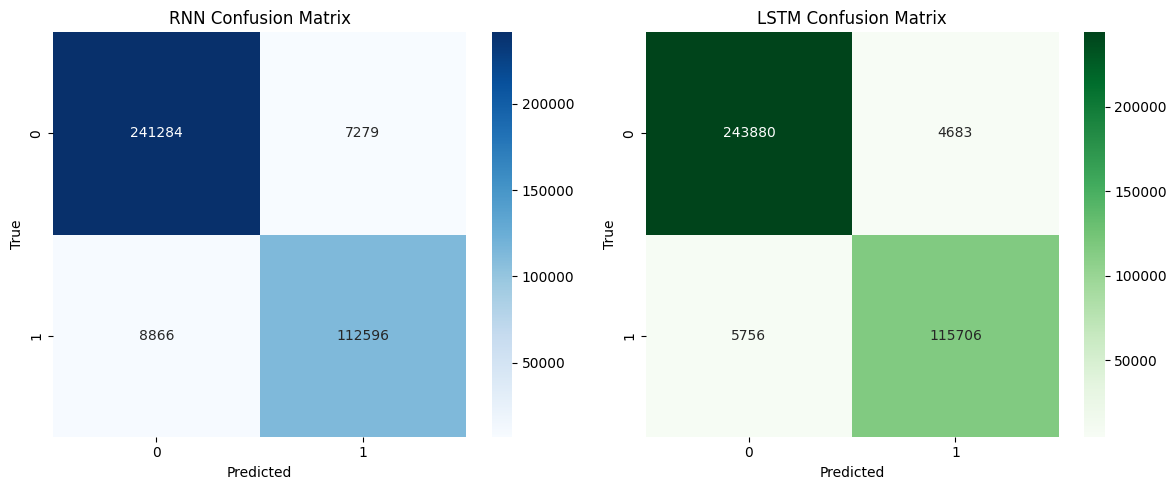

RNN Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.97      0.97    248563
           1       0.94      0.93      0.93    121462

    accuracy                           0.96    370025
   macro avg       0.95      0.95      0.95    370025
weighted avg       0.96      0.96      0.96    370025

LSTM Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.98      0.98    248563
           1       0.96      0.95      0.96    121462

    accuracy                           0.97    370025
   macro avg       0.97      0.97      0.97    370025
weighted avg       0.97      0.97      0.97    370025



In [20]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns

# Predict using trained models
rnn_preds = (rnn_model.predict(X_test_padded) > 0.5).astype("int32")
lstm_preds = (lstm_model.predict(X_test_padded) > 0.5).astype("int32")

# Accuracy
print("RNN Accuracy:", accuracy_score(y_test, rnn_preds))
print("LSTM Accuracy:", accuracy_score(y_test, lstm_preds))

# Confusion Matrices
rnn_cm = confusion_matrix(y_test, rnn_preds)
lstm_cm = confusion_matrix(y_test, lstm_preds)

# Plot Confusion Matrices
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
sns.heatmap(rnn_cm, annot=True, fmt="d", cmap="Blues", ax=ax[0])
ax[0].set_title("RNN Confusion Matrix")
ax[0].set_xlabel("Predicted")
ax[0].set_ylabel("True")

sns.heatmap(lstm_cm, annot=True, fmt="d", cmap="Greens", ax=ax[1])
ax[1].set_title("LSTM Confusion Matrix")
ax[1].set_xlabel("Predicted")
ax[1].set_ylabel("True")
plt.tight_layout()
plt.show()

# Classification Reports
print("RNN Classification Report:\n", classification_report(y_test, rnn_preds))
print("LSTM Classification Report:\n", classification_report(y_test, lstm_preds))

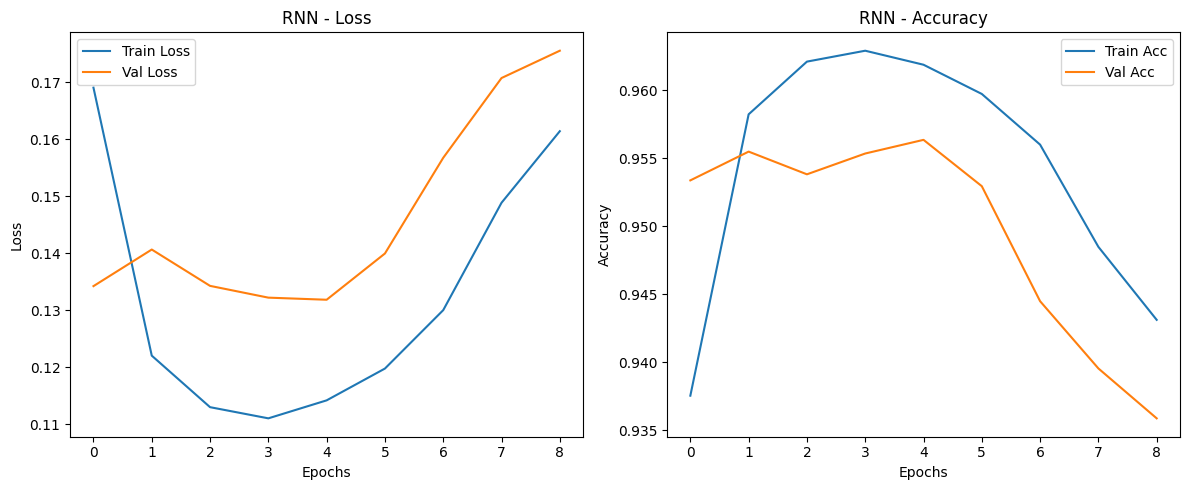

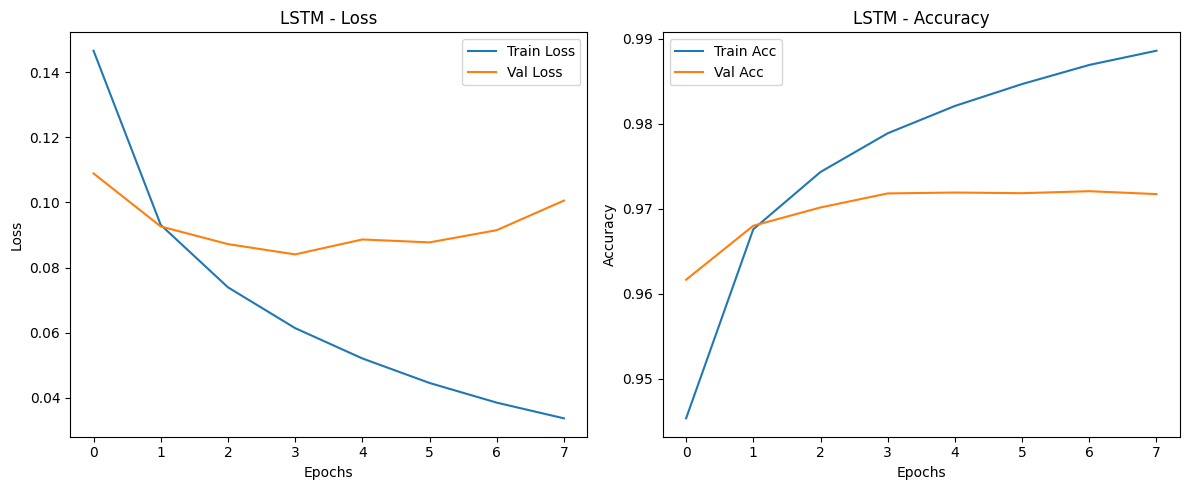

In [21]:
# Plotting function for training history
def plot_history(history, title):
    plt.figure(figsize=(12, 5))

    # Loss plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history["loss"], label="Train Loss")
    plt.plot(history.history["val_loss"], label="Val Loss")
    plt.title(f"{title} - Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    # Accuracy plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history["accuracy"], label="Train Acc")
    plt.plot(history.history["val_accuracy"], label="Val Acc")
    plt.title(f"{title} - Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.tight_layout()
    plt.show()

# Call the function for both models
plot_history(rnn_history, "RNN")
plot_history(lstm_history, "LSTM")

In [22]:
from IPython.display import display
import ipywidgets as widgets
import re
import string

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Sample dataset of tweets (positive and negative sentiment)
tweets = [
    ("I love America and its people!", 1),
    ("This administration is doing great work.", 1),
    ("Fake news is spreading lies about me.", 0),
    ("The economy is booming like never before!", 1),
    ("Corrupt politicians are ruining our country.", 0),
    ("We will make America great again!", 1),
    ("The media hates me because I tell the truth.", 0),
    ("Our military is stronger than ever.", 1),
    ("Crooked Hillary is a disgrace to politics.", 0),
    ("Together, we can achieve greatness.", 1)
]

# Separate tweets and labels
texts, labels = zip(*tweets)

# Clean text function
def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)
    text = re.sub(r'\@\w+|\#','', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = re.sub(r'\d+', '', text)
    text = text.strip()
    return text

# Preprocess the tweets
cleaned_texts = [clean_text(text) for text in texts]

# Create TF-IDF vectorizer
tfidf = TfidfVectorizer(max_features=1000)
X = tfidf.fit_transform(cleaned_texts)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.2, random_state=42)

# Train a Random Forest model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Evaluate the model
y_pred = model.predict(X_test)
print(f"Model Accuracy: {accuracy_score(y_test, y_pred):.2%}")

# Create widgets
text_input = widgets.Textarea(
    placeholder="Paste Trump tweet here...",
    layout={'width': '500px', 'height': '100px'}
)
analyze_btn = widgets.Button(description="Analyze Sentiment", button_style='success')
output = widgets.Output()

def on_analyze_click(b):
    with output:
        output.clear_output()
        text = text_input.value
        if not text.strip():
            print("⚠️ Please enter a tweet!")
            return

        cleaned_text = clean_text(text)
        text_vector = tfidf.transform([cleaned_text])
        prediction = model.predict(text_vector)[0]
        # RandomForest may not return predict_proba with very small data, handle gracefully
        if hasattr(model, "predict_proba"):
            confidence = max(model.predict_proba(text_vector)[0])
            print(f"Confidence: {confidence:.2%}")
        else:
            confidence = "Unavailable"

        sentiment = "👍 POSITIVE" if prediction == 1 else "👎 NEGATIVE"
        print(f"RESULT: {sentiment}")

analyze_btn.on_click(on_analyze_click)

display(widgets.VBox([
    widgets.Label("Trump Tweet Sentiment Analysis:"),
    text_input,
    analyze_btn,
    output
]))

Model Accuracy: 50.00%
